<a href="https://colab.research.google.com/github/swanny0000/ZTM-TensorFlow/blob/master/06_Transfer_Learning_pt_3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/25202462#content
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

SO! We've started with a small dataset, and a small model. After some experimenting and finding out what works, we've scaled up our model, then our data, etc etc etc all they way to 7500 training examples!

# Scaling up
Our goal is to beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with 10% of our training data! They had an average accuracy of 50.76% across 101 classes - let's beat it.

In [2]:
# let's get our helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
# and let's get our data! It's already been preprocessed for us
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

walk_through_dir("101_food_classes_10_percent")

--2023-12-05 03:43:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 173.194.196.207, 173.194.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   238MB/s    in 10s     

2023-12-05 03:43:55 (151 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 2

yowza!

We can import that data into a TensorFlow Dataset to make it easier to manage with code, too.

In [5]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
# let's get to training... feature extraction into fine tuning
# * ModelCheckpoint callback
# * Data augmentation layer
# * EfficientNetB0 Model
# * Feature extraction for 5 passes, using 15% of the validation dataset

checkpoint_path = "101_classes_10_percent_callback"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True)

augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(.2),
    tf.keras.layers.RandomHeight(.2),
    tf.keras.layers.RandomWidth(.2),
    tf.keras.layers.RandomZoom(.2),
    tf.keras.layers.RandomFlip("horizontal"),
    #tf.keras.layers.Rescaling(1/255.) # required for ResNetV50 or other models that expect 0-1 values
], name="augmentation_layer")

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling (GlobalAveragePool  (None, 1280)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [9]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

history_feature_extraction = model.fit(train_data_all_10_percent,
                                       epochs=5,
                                       steps_per_epoch=len(train_data_all_10_percent),
                                       validation_data=test_data,
                                       validation_steps=int(.15 * len(test_data)),
                                       callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 136s 505ms/step - loss: 3.5209 - accuracy: 0.2383 - val_loss: 2.7255 - val_accuracy: 0.4004
Epoch 2/5
237/237 [==============================] - 81s 340ms/step - loss: 2.4219 - accuracy: 0.4549 - val_loss: 2.2056 - val_accuracy: 0.4836
Epoch 3/5
237/237 [==============================] - 74s 308ms/step - loss: 2.0442 - accuracy: 0.5193 - val_loss: 1.9872 - val_accuracy: 0.5164
Epoch 4/5
237/237 [==============================] - 64s 269ms/step - loss: 1.8356 - accuracy: 0.5595 - val_loss: 1.8472 - val_accuracy: 0.5336
Epoch 5/5
237/237 [==============================] - 56s 232ms/step - loss: 1.6972 - accuracy: 0.5798 - val_loss: 1.8088 - val_accuracy: 0.5336


In [10]:
# let's see how it performs on all test examples...
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 69s 87ms/step - loss: 1.6406 - accuracy: 0.5657


wow - with 10% of the original data, and in less than 10 minutes, we beat the paper! That's the power of transfer learning!

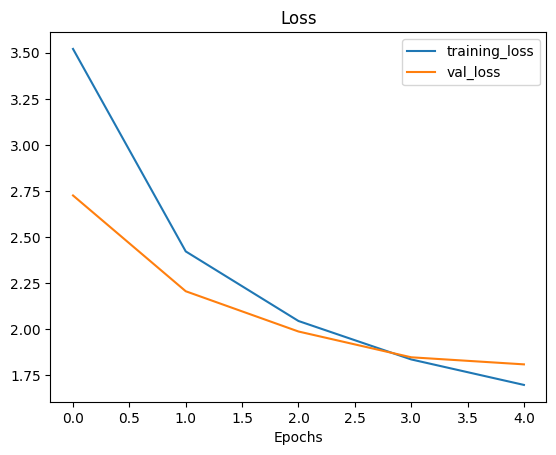

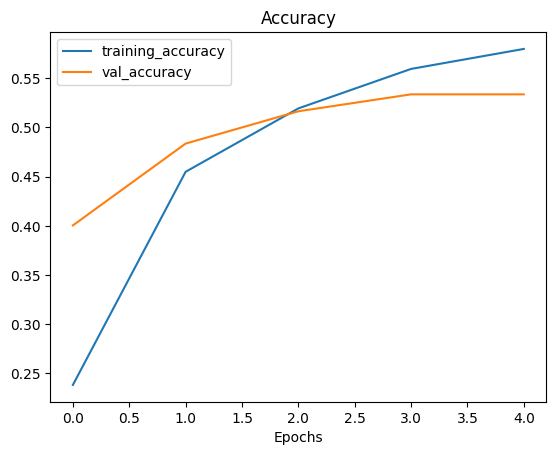

In [11]:
plot_loss_curves(history_feature_extraction)

hm, the splitting of these curves means that our model is overfitting... great! that's the first step :)

Let's get to fine tuning!

In [16]:
# unfreeze some layers and lower the learning rate!
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              metrics=["accuracy"])

model.summary()
for layer_number, layer in enumerate(model.layers[2].layers):
  if layer.trainable == True:
    print(layer_number, layer.name)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling (GlobalAveragePool  (None, 1280)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [23]:
history_fine_tuning = model.fit(train_data_all_10_percent,
                                epochs=10,
                                initial_epoch=history_feature_extraction.epoch[-1],
                                steps_per_epoch=len(train_data_all_10_percent),
                                validation_data=test_data,
                                validation_steps=int(.15*len(test_data)),
                                callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 75s 273ms/step - loss: 1.4731 - accuracy: 0.6260 - val_loss: 1.7440 - val_accuracy: 0.5389
Epoch 6/10
237/237 [==============================] - 52s 215ms/step - loss: 1.3931 - accuracy: 0.6451 - val_loss: 1.7385 - val_accuracy: 0.5424
Epoch 7/10
237/237 [==============================] - 54s 225ms/step - loss: 1.2993 - accuracy: 0.6617 - val_loss: 1.7189 - val_accuracy: 0.5448
Epoch 8/10
237/237 [==============================] - 53s 224ms/step - loss: 1.2872 - accuracy: 0.6622 - val_loss: 1.7324 - val_accuracy: 0.5418
Epoch 9/10
237/237 [==============================] - 44s 186ms/step - loss: 1.2431 - accuracy: 0.6718 - val_loss: 1.7358 - val_accuracy: 0.5395
Epoch 10/10
237/237 [==============================] - 46s 191ms/step - loss: 1.2057 - accuracy: 0.6775 - val_loss: 1.7121 - val_accuracy: 0.5469


In [24]:
# how much did validation actually improve?
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 79s 100ms/step - loss: 1.4888 - accuracy: 0.6004


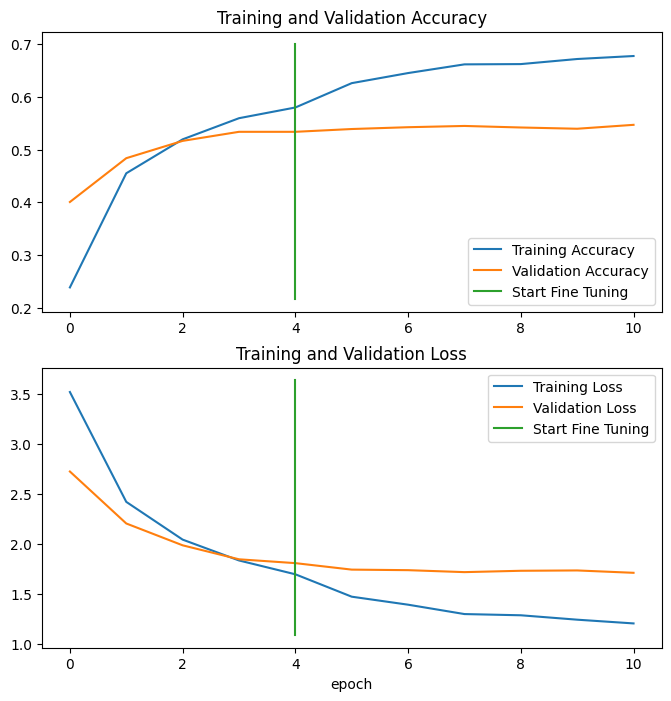

In [25]:
compare_historys(original_history=history_feature_extraction,
                 new_history=history_fine_tuning,
                 initial_epochs=5)

so for us, fine tuning really helped out with training accuracy and loss, but not for our validation datasets... we're still overfitting!

Let's look at how our model works on predicting. First, we'll need to save our model off and load it in for whatever web/phone app we'd want to use.

In [26]:
model.save("drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_model")

In [27]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_model")

In [29]:
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 63s 80ms/step - loss: 1.4888 - accuracy: 0.6004


In [30]:
loaded_model_results, fine_tuning_results

([1.4888025522232056, 0.6003564596176147],
 [1.4888025522232056, 0.6003564596176147])

## Predicting with our model

How can we fine what our model's WORST evaluations are? Let's use a presaved model to do our bidding.

In [32]:
import tensorflow as tf
# let's get our helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
# let's download another model to use
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")
pretrained_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

--2023-12-05 04:50:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.207, 209.85.147.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   188MB/s    in 0.2s    

2023-12-05 04:50:16 (188 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



we can ignore these warnings... let's make sure that's the case

In [33]:
pretrained_model_results = pretrained_model.evaluate(test_data)

790/790 [==============================] - 70s 85ms/step - loss: 1.8027 - accuracy: 0.6078


great... but how can we tell class-by-class how our model performs?

In [34]:
# let's start with visualizing a few predictions
preds_probs = pretrained_model.predict(test_data, verbose=1)

790/790 [==============================] - 73s 89ms/step


In [35]:
# how many predictions do we have? one for every test image!
len(preds_probs)

25250

In [38]:
# how many values per each test case? 101 - one for each class, since we're using a softmax function!
preds_probs.shape

(25250, 101)

In [40]:
preds_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [43]:
max(preds_probs[0]), sum(preds_probs[0]), tf.argmax(preds_probs[0])

(0.8474181, 0.9999999913078492, <tf.Tensor: shape=(), dtype=int64, numpy=52>)

In [45]:
# what class is that?
test_data.class_names[52]

'gyoza'

In [47]:
# let's get teh pred classes from each array...
pred_classes = preds_probs.argmax(axis=1)

In [ ]:
# how can we tell what predictions are correct and incorrect?
